Mestrado em Modelagem Matematica da Informacao
----------------------------------------------
Disciplina: Modelagem e Mineracao de Dados
------------------------------------------

Master Program - Mathematical Modeling of Information
-----------------------------------------------------
Course: Data Mining and Modeling
--------------------------------

Professor: Renato Rocha Souza
-----------------------------

### Topic: Clustering documents

This notebook is based on http://www.brandonrose.org and http://www.brandonrose.org/top100  
The explanation is totally based on: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/  

In [9]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from bs4 import BeautifulSoup
import re
import os
import codecs
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import feature_extraction
import mpld3
import pyLDAvis
import pyLDAvis.gensim
from IPython.display import Image

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationW

### Introduction

Analytics Industry is all about obtaining the “Information” from the data. With the growing amount of data in recent years, that too mostly unstructured, it’s difficult to obtain the relevant and desired information. But, technology has developed some powerful methods which can be used to mine through the data and fetch the information that we are looking for.  

One such technique in the field of text mining is Topic Modelling. As the name suggests, it is a process to automatically identify topics present in a text object and to derive hidden patterns exhibited by a text corpus. Thus, assisting better decision making.  

Topic Modelling is different from rule-based text mining approaches that use regular expressions or dictionary based keyword searching techniques. It is an unsupervised approach used for finding and observing the bunch of words (called “topics”) in large clusters of texts.  

Topics can be defined as “a repeating pattern of co-occurring terms in a corpus”. A good topic model should result in – “health”, “doctor”, “patient”, “hospital” for a topic – Healthcare, and “farm”, “crops”, “wheat” for a topic – “Farming”.  

Topic Models are very useful for the purpose for document clustering, organizing large blocks of textual data, information retrieval from unstructured text and feature selection. For Example – New York Times are using topic models to boost their user – article recommendation engines. Various professionals are using topic models for recruitment industries where they aim to extract latent features of job descriptions and map them to right candidates. They are being used to organize large datasets of emails, customer reviews, and user social media profiles.  

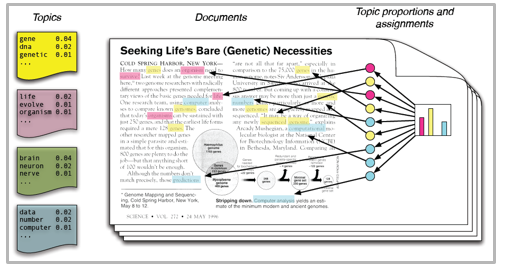

In [3]:
#Image(url='https://www.analyticsvidhya.com/wp-content/uploads/2016/08/Modeling1.png')
Image(filename='../slides/Modeling1.png')

### Latent Dirichlet Allocation for Topic Modeling  

There are many approaches for obtaining topics from a text such as – Term Frequency and Inverse Document Frequency. NonNegative Matrix Factorization techniques. Latent Dirichlet Allocation is the most popular topic modeling technique and in this article, we will discuss the same.  

LDA assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. Given a dataset of documents, LDA backtracks and tries to figure out what topics would create those documents in the first place.  

LDA is a matrix factorization technique. In vector space, any corpus (collection of documents) can be represented as a document-term matrix. The following matrix shows a corpus of N documents D1, D2, D3 … Dn and vocabulary size of M words W1,W2 .. Wn. The value of i,j cell gives the frequency count of word Wj in Document Di.  

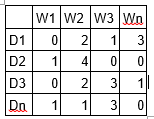

In [10]:
#Image(url='https://www.analyticsvidhya.com/wp-content/uploads/2016/08/Modeling2.png')
Image(filename='../slides/Modeling2.png')

LDA converts this Document-Term Matrix into two lower dimensional matrices – M1 and M2.
M1 is a document-topics matrix and M2 is a topic – terms matrix with dimensions (N,  K) and (K, M) respectively, where N is the number of documents, K is the number of topics and M is the vocabulary size.  

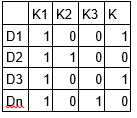

In [6]:
Image(filename='../slides/modeling3.png')

Notice that these two matrices already provides topic word and document topic distributions, However, these distribution needs to be improved, which is the main aim of LDA. LDA makes use of sampling techniques in order to improve these matrices.  

It Iterates through each word “w” for each document “d” and tries to adjust the current topic – word assignment with a new assignment. A new topic “k” is assigned to word “w” with a probability P which is a product of two probabilities p1 and p2.  

For every topic, two probabilities p1 and p2 are calculated. P1 – p(topic t / document d) = the proportion of words in document d that are currently assigned to topic t. P2 – p(word w / topic t) = the proportion of assignments to topic t over all documents that come from this word w.  

The current topic – word assignment is updated with a new topic with the probability, product of p1 and p2 . In this step, the model assumes that all the existing word – topic assignments except the current word are correct. This is essentially the probability that topic t generated word w, so it makes sense to adjust the current word’s topic with new probability.  

After a number of iterations, a steady state is achieved where the document topic and topic term distributions are fairly good. This is the convergence point of LDA.  

 
#### Parameters of LDA  

Alpha and Beta Hyperparameters – alpha represents document-topic density and Beta represents topic-word density. Higher the value of alpha, documents are composed of more topics and lower the value of alpha, documents contain fewer topics. On the other hand, higher the beta, topics are composed of a large number of words in the corpus, and with the lower value of beta, they are composed of few words.  

Number of Topics – Number of topics to be extracted from the corpus. Researchers have developed approaches to obtain an optimal number of topics by using Kullback Leibler Divergence Score. I will not discuss this in detail, as it is too mathematical. For understanding, one can refer to this[1] original paper on the use of KL divergence.  

Number of Topic Terms – Number of terms composed in a single topic. It is generally decided according to the requirement. If the problem statement talks about extracting themes or concepts, it is recommended to choose a higher number, if problem statement talks about extracting features or terms, a low number is recommended.  

Number of Iterations / passes – Maximum number of iterations allowed to LDA algorithm for convergence.  

In [7]:
# Here are the sample documents combining together to form a corpus.

doc1 = "Sugar is bad to consume. My sister likes to have sugar, but not my father."
doc2 = "My father spends a lot of time driving my sister around to dance practice."
doc3 = "Doctors suggest that driving may cause increased stress and blood pressure."
doc4 = "Sometimes I feel pressure to perform well at school, but my father never seems to drive my sister to do better."
doc5 = "Health experts say that Sugar is not good for your lifestyle."

# compile documents
doc_complete = [doc1, doc2, doc3, doc4, doc5]

#### Cleaning and Preprocessing

Cleaning is an important step before any text mining task, in this step, we will remove the punctuations, stopwords and normalize the corpus.  

In [ ]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]   

#### Preparing Document-Term Matrix

All the text documents combined is known as the corpus. To run any mathematical model on text corpus, it is a good practice to convert it into a matrix representation. LDA model looks for repeating term patterns in the entire DT matrix. Python provides many great libraries for text mining practices, “gensim” is one such clean and beautiful library to handle text data. It is scalable, robust and efficient. Following code shows how to convert a corpus into a document-term matrix.  

In this guide, I will explain how to cluster a set of documents using Python. My motivating example is to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list). 

This notebook covers:

<ul>
<li> tokenizing and stemming each synopsis
<li> transforming the corpus into vector space using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
<li> calculating cosine distance between each document as a measure of similarity
<li> clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
<li> using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus
<li> plotting the clustering output using [matplotlib](http://matplotlib.org/) and [mpld3](http://mpld3.github.io/)
<li> conducting a hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
<li> plotting a Ward dendrogram
<li> topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
</ul>

## Contents

<ul>
<li>[Stopwords, stemming, and tokenization](#Stopwords,-stemming,-and-tokenizing)
<li>[Tf-idf and document similarity](#Tf-idf-and-document-similarity)
<li>[K-means clustering](#K-means-clustering)
<li>[Multidimensional scaling](#Multidimensional-scaling)
<li>[Visualizing document clusters](#Visualizing-document-clusters)
<li>[Hierarchical document clustering](#Hierarchical-document-clustering)
<li>[Latent Dirichlet Allocation (LDA)](#Latent-Dirichlet-Allocation)
</ul>

But first, I import everything I am going to need up front

Specifying the path to the files  

In [2]:
datapath = "../datasets/texts/doccluster/"
outputs = "../outputs/"

#### import three lists: titles, links and wikipedia synopses  

In [49]:
titles = open(os.path.join(datapath, 'title_list.txt')).read().split('\n')
#ensures that only the first 100 are read in
titles = titles[:100]
print(str(len(titles)) + ' titles')

print(titles[0:5])

100 titles
['The Godfather', 'The Shawshank Redemption', "Schindler's List", 'Raging Bull', 'Casablanca']


In [4]:
links = open(os.path.join(datapath, 'link_list_imdb.txt')).read().split('\n')
links = links[:100]
print(str(len(links)) + ' links')

print(links[0:5])

100 links
['http://www.imdb.com/title/tt0068646/', 'http://www.imdb.com/title/tt0111161/', 'http://www.imdb.com/title/tt0108052/', 'http://www.imdb.com/title/tt0081398/', 'http://www.imdb.com/title/tt0034583/']


In [5]:
synopses_wiki = open(os.path.join(datapath, 'synopses_list_wiki.txt')).read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)
synopses_wiki = synopses_clean_wiki

print(str(len(synopses_wiki)) + ' synopses')

print(synopses_wiki[0][0:300])

100 synopses
 Plot  [edit]  [  [  edit  edit  ]  ]  
  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the spra


In [6]:
genres = open(os.path.join(datapath,'genres_list.txt')).read().split('\n')
genres = genres[:100]
print(str(len(genres)) + ' genres')

print(genres[0:5])

100 genres
["[u' Crime', u' Drama']", "[u' Crime', u' Drama']", "[u' Biography', u' Drama', u' History']", "[u' Biography', u' Drama', u' Sport']", "[u' Drama', u' Romance', u' War']"]


In [7]:
synopses_imdb = open(os.path.join(datapath,'synopses_list_imdb.txt')).read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]
synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [8]:
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [9]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

### Stopwords, stemming, and tokenizing

This section is focused on defining some functions to manipulate the synopses. First, I load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. I'm sure there are much better explanations of this out there.

In [10]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [11]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below I define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!



In [12]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [13]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [14]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

### Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, 
                                   max_features=200000,
                                   min_df=0.2, 
                                   stop_words='english',
                                   use_idf=True, 
                                   tokenizer=tokenize_and_stem, 
                                   ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

CPU times: user 10 s, sys: 64 ms, total: 10.1 s
Wall time: 10.1 s
(100, 563)


In [16]:
terms = tfidf_vectorizer.get_feature_names()

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

### K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [18]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 84 ms, sys: 0 ns, total: 84 ms
Wall time: 85.6 ms


In [19]:
from sklearn.externals import joblib

joblib.dump(km, os.path.join(outputs, 'doc_cluster.pkl'))
km = joblib.load(os.path.join(outputs, 'doc_cluster.pkl'))
clusters = km.labels_.tolist()

In [20]:
films = {'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [21]:
frame.head()

/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


,rank,title,cluster,genre
0,0,The Godfather,0,"[u' Crime', u' Drama']"
0,1,The Shawshank Redemption,0,"[u' Crime', u' Drama']"
0,2,Schindler's List,0,"[u' Biography', u' Drama', u' History']"
3,3,Raging Bull,3,"[u' Biography', u' Drama', u' Sport']"
0,4,Casablanca,0,"[u' Drama', u' Romance', u' War']"


In [22]:
frame['cluster'].value_counts()

3    37
1    26
0    23
2    10
4     4
Name: cluster, dtype: int64

In [23]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0    37.695652
1    45.461538
2    74.300000
3    52.945946
4    49.750000
Name: rank, dtype: float64

In [24]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'family', b'war', b'prison', b'home', b'house', b'help',

Cluster 0 titles: The Godfather, The Shawshank Redemption, Schindler's List, Casablanca, Gone with the Wind, The Wizard of Oz, Titanic, The Godfather: Part II, The Sound of Music, E.T. the Extra-Terrestrial, The Silence of the Lambs, Amadeus, The Best Years of Our Lives, Ben-Hur, Doctor Zhivago, High Noon, The Pianist, Goodfellas, Giant, The Grapes of Wrath, Network, A Clockwork Orange, Yankee Doodle Dandy,

Cluster 1 words: b'killed', b'soldiers', b'army', b'men', b'command', b'orders',

Cluster 1 titles: One Flew Over the Cuckoo's Nest, Lawrence of Arabia, Star Wars, 2001: A Space Odyssey, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Saving Private Ryan, Unforgiven, Raiders of the Lost Ark, Patton, Jaws, Braveheart, Butch Cassidy and th

In [25]:
#This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['title']

In [26]:
#export tables to HTML
html_output = frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False)

from IPython.core.display import display, HTML
display(HTML(html_output))

Rank,Title
6,One Flew Over the Cuckoo's Nest
11,Lawrence of Arabia
20,Star Wars
22,2001: A Space Odyssey
25,The Bridge on the River Kwai
30,Dr. Strangelove or: How I Learned to Stop Worr...
32,Apocalypse Now
34,The Lord of the Rings: The Return of the King
35,Gladiator
36,From Here to Eternity


### Multidimensional scaling

In [27]:
from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [28]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

### Visualizing document clusters

In [29]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

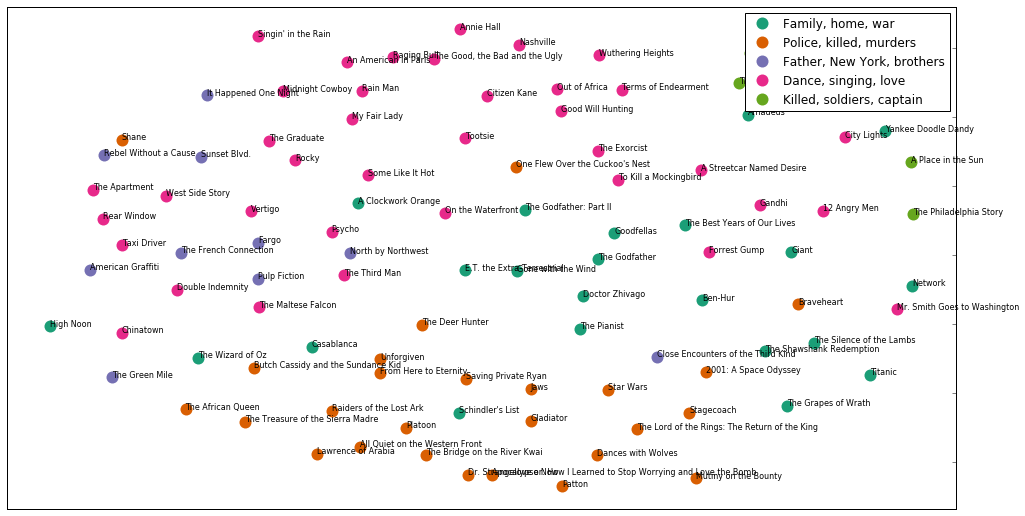

In [30]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

plt.show()

#Saving the Fig
plt.savefig(os.path.join(outputs,'clusters_small_noaxes.png'), dpi=200)

The clustering plot looks great, but it would be better without overlapping labels. We are going to use D3.js (http://d3js.org/), a browser based/javascript interactive. We will use a matplotlib D3 wrapper called mpld3 (https://mpld3.github.io/). Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. Don't worry about it too much and you actually don't need to use it, but it helped for formatting purposes when exporting to the web later. The only thing you might want to change is the x and y attr for the position of the toolbar.

In [31]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [32]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

In [33]:
#uncomment the below to export to html
#os.chdir(outputs)
#html = mpld3.fig_to_html(fig)
#print(html)

### Hierarchical document clustering

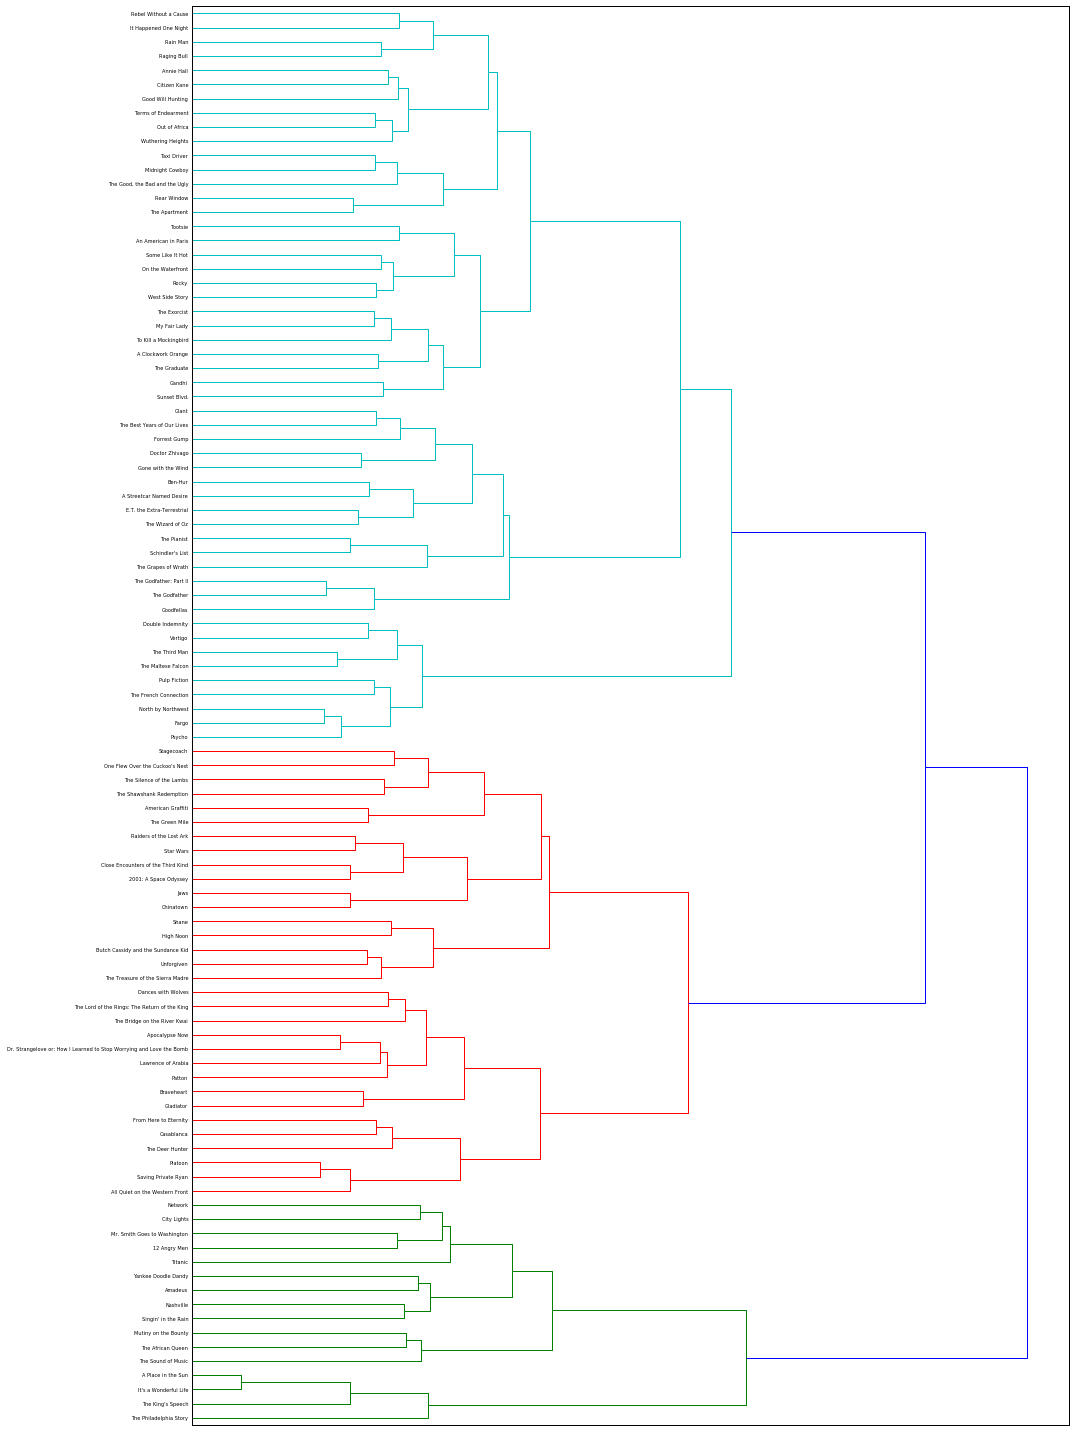

In [34]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig(os.path.join(outputs,'ward_clusters.png'), dpi=200)

### Latent Dirichlet Allocation

In [35]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [36]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [37]:
#Latent Dirichlet Allocation implementation with Gensim
from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in synopses]

%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/theano/configparser.py:81: DeprecationWarning: The SafeConfigParser class has been renamed to ConfigParser in Python 3.2. This alias will be removed in future versions. Use ConfigParser directly instead.
  'PID': str(os.getpid()),
Using gpu device 0: Quadro K4200 (CNMeM is disabled, cuDNN 5103)
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/numpy/lib/utils.py:99: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  warnings.warn(depdoc, DeprecationWarning)


CPU times: user 5.1 s, sys: 8 ms, total: 5.11 s
Wall time: 5.11 s
CPU times: user 436 ms, sys: 8 ms, total: 444 ms
Wall time: 445 ms


In [38]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))

1839


In [39]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.8)
corpus = [dictionary.doc2bow(text) for text in texts]

In [40]:
len(corpus)

100

In [41]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 6min 36s, sys: 408 ms, total: 6min 36s
Wall time: 6min 36s


In [42]:
print(lda[corpus[0]])

[(1, 0.26478744250099723), (4, 0.7329371649041525)]


In [43]:
topics = lda.print_topics(5, num_words=20)

In [47]:
lda.show_topics()

[(0,
  '0.005*father + 0.005*ask + 0.004*kill + 0.004*fight + 0.004*also + 0.004*famili + 0.004*friend + 0.003*death + 0.003*order + 0.003*meet'),
 (1,
  "0.008*car + 0.006*go + 0.005*meet + 0.005*n't + 0.005*kill + 0.005*call + 0.005*ask + 0.004*day + 0.004*drive + 0.004*polic"),
 (2,
  '0.007*shark + 0.007*kill + 0.005*boat + 0.005*water + 0.004*fight + 0.004*two + 0.004*soldier + 0.004*prison + 0.004*night + 0.004*ask'),
 (3,
  '0.006*kill + 0.005*men + 0.005*home + 0.004*arriv + 0.004*two + 0.004*say + 0.004*order + 0.004*apart + 0.003*ask + 0.003*love'),
 (4,
  "0.007*famili + 0.004*father + 0.004*kill + 0.004*home + 0.004*friend + 0.004*life + 0.003*help + 0.003*meet + 0.003*n't + 0.003*say")]

In [44]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

In [45]:
topics_matrix[0]

(0,
 [('father', 0.0053252369418388028),
  ('ask', 0.0048209459874065793),
  ('kill', 0.0042974882459597633),
  ('fight', 0.0037502840109423954),
  ('also', 0.0036179980790737652),
  ('famili', 0.0035445462482726529),
  ('friend', 0.0035318361072976144),
  ('death', 0.0034429056599379632),
  ('order', 0.0033304890486893206),
  ('meet', 0.0033094557969955861),
  ('home', 0.0033034779976071926),
  ('say', 0.003221093898243676),
  ('decid', 0.0031777153335400634),
  ('come', 0.0030866110581128491),
  ('end', 0.0029847022058097018),
  ('vote', 0.0029613612688236895),
  ('becom', 0.0029607192340169934),
  ('brother', 0.002958690186620041),
  ('wife', 0.0029358833419874937),
  ('film', 0.0029286700156477045)])

In [46]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      26.539389        1       1  0.027178  0.085348
4      24.868429        1       2  0.035035  0.003796
3      24.031596        1       3 -0.007587  0.004245
0      12.516695        1       4  0.056671 -0.076290
2      12.043892        1       5 -0.111297 -0.017099, topic_info=     Category        Freq      Term       Total  loglift  logprob
term                                                             
2073  Default  106.000000     shark  106.000000  30.0000  30.0000
6813  Default  306.000000       car  306.000000  29.0000  29.0000
7300  Default  344.000000    famili  344.000000  28.0000  28.0000
3253  Default  140.000000     water  140.000000  27.0000  27.0000
2880  Default  111.000000      boat  111.000000  26.0000  26.0000
1824  Default  317.000000    father  317.000000  25.0000  25.0000
174   Default  159.000000    prison  159.000000  24.0000  24.0000
4334  Default  199.000000   soldier  199.000000  23.0000  23.0000
7238  Default  258.000000     fight  258.000000  22.0000  22.0000
500   Default   51.000000    guilti   51.000000  21.0000  21.0000
7466  Default   55.000000      vote   55.000000  20.0000  20.0000
694   Default   47.000000     beach   47.000000  19.0000  19.0000
4982  Default  593.000000      kill  593.000000  18.0000  18.0000
5115  Default   28.000000     juror   28.000000  17.0000  17.0000
7793  Default   28.000000   gladiat   28.000000  16.0000  16.0000
2309  Default   54.000000     river   54.000000  15.0000  15.0000
2702  Default   71.000000     hotel   71.000000  14.0000  14.0000
7756  Default  116.000000     guard  116.000000  13.0000  13.0000
1323  Default  320.000000       men  320.000000  12.0000  12.0000
7050  Default  138.000000  children  138.000000  11.0000  11.0000
6816  Default   63.000000     bridg   63.000000  10.0000  10.0000
1039  Default  101.000000      camp  101.000000   9.0000   9.0000
1509  Default  175.000000   brother  175.000000   8.0000   8.0000
6021  Default  298.000000     order  298.000000   7.0000   7.0000
4672  Default   99.000000    execut   99.000000   6.0000   6.0000
1118  Default   41.000000      bomb   41.000000   5.0000   5.0000
5050  Default  437.000000       ask  437.000000   4.0000   4.0000
6460  Default   22.000000    warden   22.000000   3.0000   3.0000
3037  Default   35.000000       pod   35.000000   2.0000   2.0000
1025  Default   66.000000      hang   66.000000   1.0000   1.0000
...       ...         ...       ...         ...      ...      ...
4182   Topic5   17.162939      cell   27.864004   1.6320  -6.7115
1025   Topic5   28.033078      hang   66.071133   1.2593  -6.2209
4334   Topic5   53.383570   soldier  199.422714   0.7987  -5.5767
4982   Topic5   95.981684      kill  593.888556   0.2941  -4.9901
7238   Topic5   60.182171     fight  258.731218   0.6582  -5.4569
8006   Topic5   20.738643   captain   41.821860   1.4152  -6.5222
5037   Topic5   28.667223      line   81.595282   1.0706  -6.1985
7040   Topic5   59.636867       two  391.133864   0.2358  -5.4660
517    Topic5   50.576541     night  347.233076   0.1901  -5.6308
1323   Topic5   48.522751       men  320.564603   0.2286  -5.6722
1258   Topic5   41.203047     shoot  222.390530   0.4307  -5.8357
5412   Topic5   39.912672       use  222.623673   0.3978  -5.8675
8050   Topic5   48.113621     arriv  377.757218   0.0559  -5.6807
61     Topic5   36.173741    attack  193.617835   0.4391  -5.9659
5050   Topic5   49.713560       ask  437.338623  -0.0578  -5.6480
7217   Topic5   40.626883      help  274.923942   0.2045  -5.8498
1688   Topic5   41.494539       doe  295.872705   0.1522  -5.8287
1545   Topic5   45.457566       n't  380.496566  -0.0081  -5.7375
331    Topic5   41.130298     first  300.165809   0.1290  -5.8375
1785   Topic5   38.580985   attempt  252.190676   0.2392  -5.9015
4359   Topic5   39.631323       goe  288.215618   0.1325  -5.8746
5086   Topic5  